# Simulation Based Inference For NeuroScience: The BOLD signal

## Table Of Content:
* [Setup](#set-up)
* [Train a Density Estimator](#density-estimator)
* [Creating X](#creating-X)
* [Loading Simulation Results](#simulation)
* [Training the Neural Network](#training)
* [Validating Results & Saving Plots](#validation)

## Setup<a class="anchor" id="set-up"></a>

First import the needed libraries (and set current working directory if needed).

In [1]:
# If needed, before starting, change the current working directory by uncommenting and inserting the right path:
# os.chdir("/home/coder/projects/lorenz_sbi")

# System/IO Libraries 
import os
from datetime import datetime
from tqdm import tqdm
import sys


# General libraries:
import numpy as np
import pylab as plt
import argparse 
import torch 

# SBI Methods 
from sbi.inference import SNPE, SNLE, SNRE

# For plotting:
# from sbi.analysis import pairplot, conditional_pairplot
from utils import *

# Custom Functions:
from train import train
from test import test_posterior, return_single_results, print_stats

# Get the path of the current working directory: 
cwd_path = os.getcwd()

## Train a density estimator<a class="anchor" id="density-estimator"></a>

When training the model, be aware the change the second line of the code to the desired training set:

"parser.add_argument("--data", type=str, default=cwd_path + "/data/X_train_01.npy", help="Path to the data file.")"

In [2]:
# Train a density estimator.
# If desired, change the number of threads to a higher number (by default it's 1).
parser = argparse.ArgumentParser(description="Train a density estimator.")
parser.add_argument("--data", type=str, default=cwd_path + "/data/X_train_01.npy", help="Path to the data file.")
parser.add_argument("--method", type=str, default="SNPE", help="Inference method.")
parser.add_argument("--density_estimator", type=str, default="maf", help="Density estimator.")
parser.add_argument("--num_threads", type=int, default=1, help="Number of threads.")
parser.add_argument("--device", type=str, default="cpu", help="Device.")

args, unknown = parser.parse_known_args()

## Creating X with "old betas"<a class="anchor" id="creating-X"></a>

In [3]:
# Read in beta files (input to our NN).
# First read in 1 file:
# betas = np.load(cwd_path + "/data/Betas_01.npy")

# # Append the rest of the beta batches to this file:
# for number in range(2, 11):
#     #print(number)
#     if number <= 9:
#         beta_files = np.load(cwd_path + "/data/Betas_0" + str(number) + ".npy")
#         betas = np.concatenate((betas, beta_files))
#     else:
#         beta_files = np.load(cwd_path + "/data/Betas_10.npy")
#         betas = np.concatenate((betas, beta_files))

# # Read in our parameters.
# total_combinations = np.load(cwd_path + "/data/total_combinations.npy")


# # Check whether the number of rows match between our parameters and beta values.
# print("Does the length match between the parameters and the beta value (returns True if this is true)?", len(total_combinations) == len(betas))

# # Concatenate both together:
# X = np.concatenate((total_combinations, betas), axis = 1)

# print("The shape of X is: ", X.shape)
# print("The first row/simulation in X is: ", "\n", X[0])

# np.save(cwd_path + "/data/X.npy", X)

## Creating X with "new betas"<a class="anchor" id="creating-X"></a>

In [4]:
# Read in beta files (input to our NN).
# First read in 1 file:
# new_betas = np.load(cwd_path + "/data/Betas_inh_exc_summed_01.npy")

# # Append the rest of the beta batches to this file:
# for number in range(2, 11):
#     #print(number)
#     if number <= 9:
#         new_beta_files = np.load(cwd_path + "/data/Betas_inh_exc_summed_0" + str(number) + ".npy")
#         new_betas = np.concatenate((new_betas, new_beta_files))
#     else:
#         new_beta_files = np.load(cwd_path + "/data/Betas_inh_exc_summed_10.npy")
#         new_betas = np.concatenate((new_betas, new_beta_files))

# # Read in our parameters.
# total_combinations = np.load(cwd_path + "/data/total_combinations.npy")

# # Check whether the number of rows match between our parameters and beta values.
# print("Does the length match between the parameters and the beta value (returns True if this is true)?", len(total_combinations) == len(new_betas))

# # Concatenate both together:
# X_with_new_betas = np.concatenate((total_combinations, new_betas), axis = 1)

# print("The shape of X is: ", X_with_new_betas.shape)
# print("The first row/simulation in X is: ", "\n", X_with_new_betas[0])

# np.save(cwd_path + "/data/X_with_new_betas.npy", X_with_new_betas)

## Loading Simulation Results<a class="anchor" id="simulation"></a>

As shuffle is not deterministic (as np.random.seed() does not work as intended), we will save our X_train and X_test instead.

We will make 3 models for the "old betas" called posterior_01, posterior_02 and posterior_03. Their corresponding training and test data (present in the data map) are respectively: 
-	X_train_01 with X_test_01
-	X_train_02 with X_test_02
-	X_train_03 with X_test_03

So as example: the model "posterior_01" is trained with X_train_01 (so you need to test this model with X_test_01). Same for the other 2 models but then with the 02 and 03 files.

We will also make 3 models for the "new betas" called posterior_with_new_betas_01, posterior_with_new_betas_02 and posterior_with_new_betas_03. Their corresponding training and test data (present in the data map) are respectively: 
-	X_train_new_betas_01 with X_test_new_betas_01
-	X_train_new_betas_02 with X_test_new_betas_02
-	X_train_new_betas_03 with X_test_new_betas_03

Again as example: the model "posterior_with_new_betas_01" is trained with X_train_new_betas_01 (so you need to test this model with X_test_new_betas_01). Same for the other 2 models but then with the 02 and 03 files.

The reason to train multiple models is to avoid that by chance a better train/test set is generated which can lead to optimistic/worse results.

In [5]:
# Change the line below to the desired X that you want to import.
# X.npy in data map contains the "old betas" and X_with_new_betas.npy contains the "new betas".
# X = np.load(cwd_path + "/data/X.npy")
# print(X.shape)
# print(X[0])

# # Split this matrix into train and test data.

# # Shuffle the X to make sure different combinations end up in the train and test sets.
# np.random.shuffle(X)

# # Take 10% of the data for test (there are 11520 simulations in X, 10% is 1152 which goes to test, the rest goes to X_train).
# X_train = X[:10368, :]
# X_test = X[10368:, :]

# # Save this train and test set; specify the files you want the train and test data to be saved to.
# np.save(cwd_path + "/data/X_train_[...].npy", X_train)
# np.save(cwd_path + "/data/X_test_[...].npy", X_test)

## Training the Neural Network <a class="anchor" id="training"></a>

There is a pretrained posterior present in the models map. If you want to retrain it, uncomment the block of code below before running it.

In [6]:
# Change the 2 lines below to load the desired train and test set (here I loaded X_train_01 and X_test_01)
# which is with the "old betas" (first run from the triplo).
# X_train_01 = np.load(args.data, allow_pickle=True)
# X_test_01 = np.load(cwd_path + "/data/X_test_01.npy")

# # Establish how many simulations are in the data 
# num_simulations = X_train_01.shape[0]

# # Seperate simulation parameters and summary statistics
# params = X_train_01[:, -4:]
# stats  = X_train_01[:, :-4]

# # When working with Torch, the matrix has to be parsed to a Torch object 
# theta = torch.from_numpy(params).float()
# x = torch.from_numpy(stats).float()

# # Train the posterior with all the arguments needed 
# posterior = train(num_simulations,
#                     x,
#                     theta,
#                     num_threads         = args.num_threads,
#                     method              = args.method,
#                     device              = args.device,
#                     density_estimator   = args.density_estimator
#                     )

# # Save posterior (intermediate result); specify the files you want the train and test data to be saved to.
# torch.save(posterior, cwd_path + "/models/posterior_[...].pt")

## Validating Results & Saving Plots <a class="anchor" id="validation"></a>

*Warning: when this code is run 1152 pairplots and correlation plots will be saved in the png-map! (for every simulation 2 plots and we have 1152 simulations as test data).*

To-do: change the for-loop to display the plot in a different way (don't use pairplots) & incorporate the error between the actual value and the inferred parameter values.

In [38]:

extensions = {"posterior": ".pt", "test": ".npy"}

# posterior_prefix = "posterior_0"
# posterior_prefix = "posterior_with_new_betas_0"
posterior_prefix = "posterior_with_all_data_"

# test_mat_prefix = "X_test_0"
test_mat_prefix = "all_data_test_"

posterior_models = []
testing_data = []

for root, dirs, files in os.walk(cwd_path + "/models/"):
    for name in files:
        if posterior_prefix in name:
            posterior_models.append([name, torch.load(os.path.join(root, name))])

for root, dirs, files in os.walk(cwd_path + "/data/"):
    for name in files:
        if test_mat_prefix in name:
            testing_data.append([name , np.load(os.path.join(root, name))])
            
posterior_models = np.array(posterior_models, dtype=object)
testing_data = np.array(testing_data, dtype=object)
combi = np.array([[posterior_models[i],testing_data[i]] for i in range(len(testing_data))])
test_results_arr = []


run_tests = False

threshold = 0.3
tolerance = 1.0
activation_threshold = 10.0
num_samples = 500

# cur_test_name = "test_suite_" + str(datetime.now())[5:10] + "_" + str(datetime.now())[11:-7].replace(":","_")
cur_test_name = "test_suite_10-26_21_13_56"

if run_tests:
    print("Running tests for models: ")
    for posterior in posterior_models:
        print(posterior[0])
    print()
    for (posterior, test_matrix) in combi:
        test_results_arr.append(
            test_posterior(
                posterior[1], 
                test_matrix[1], 
                num_samples = num_samples, 
                threshold = threshold, 
                tolerance = tolerance,
                activation_threshold = activation_threshold,
                posterior_name = posterior[0])
        )
    np.save(os.path.join(cwd_path,"test_results",cur_test_name), test_results_arr)
else:
    print("Loading tests results: ", cur_test_name)
    print("Testing Parameters: ")
    with open(os.path.join(cwd_path,"plot_images",cur_test_name,"test_params.txt")) as f:
        for line in f.readlines():
            print("\t",line[:-1])
    test_results_arr = np.load(os.path.join(cwd_path,"test_results",cur_test_name + ".npy"), allow_pickle=True)

Loading tests results:  test_suite_10-26_21_13_56
Testin Parameters: 
	 Threshold: 0.3
	 Tolerance: 1.0
	 Activation Threshold: 10.0
	 Number of Samples: 500


Saving plots...
  0%|          | 0/10 [00:02<?, ? model/s]


KeyboardInterrupt: 

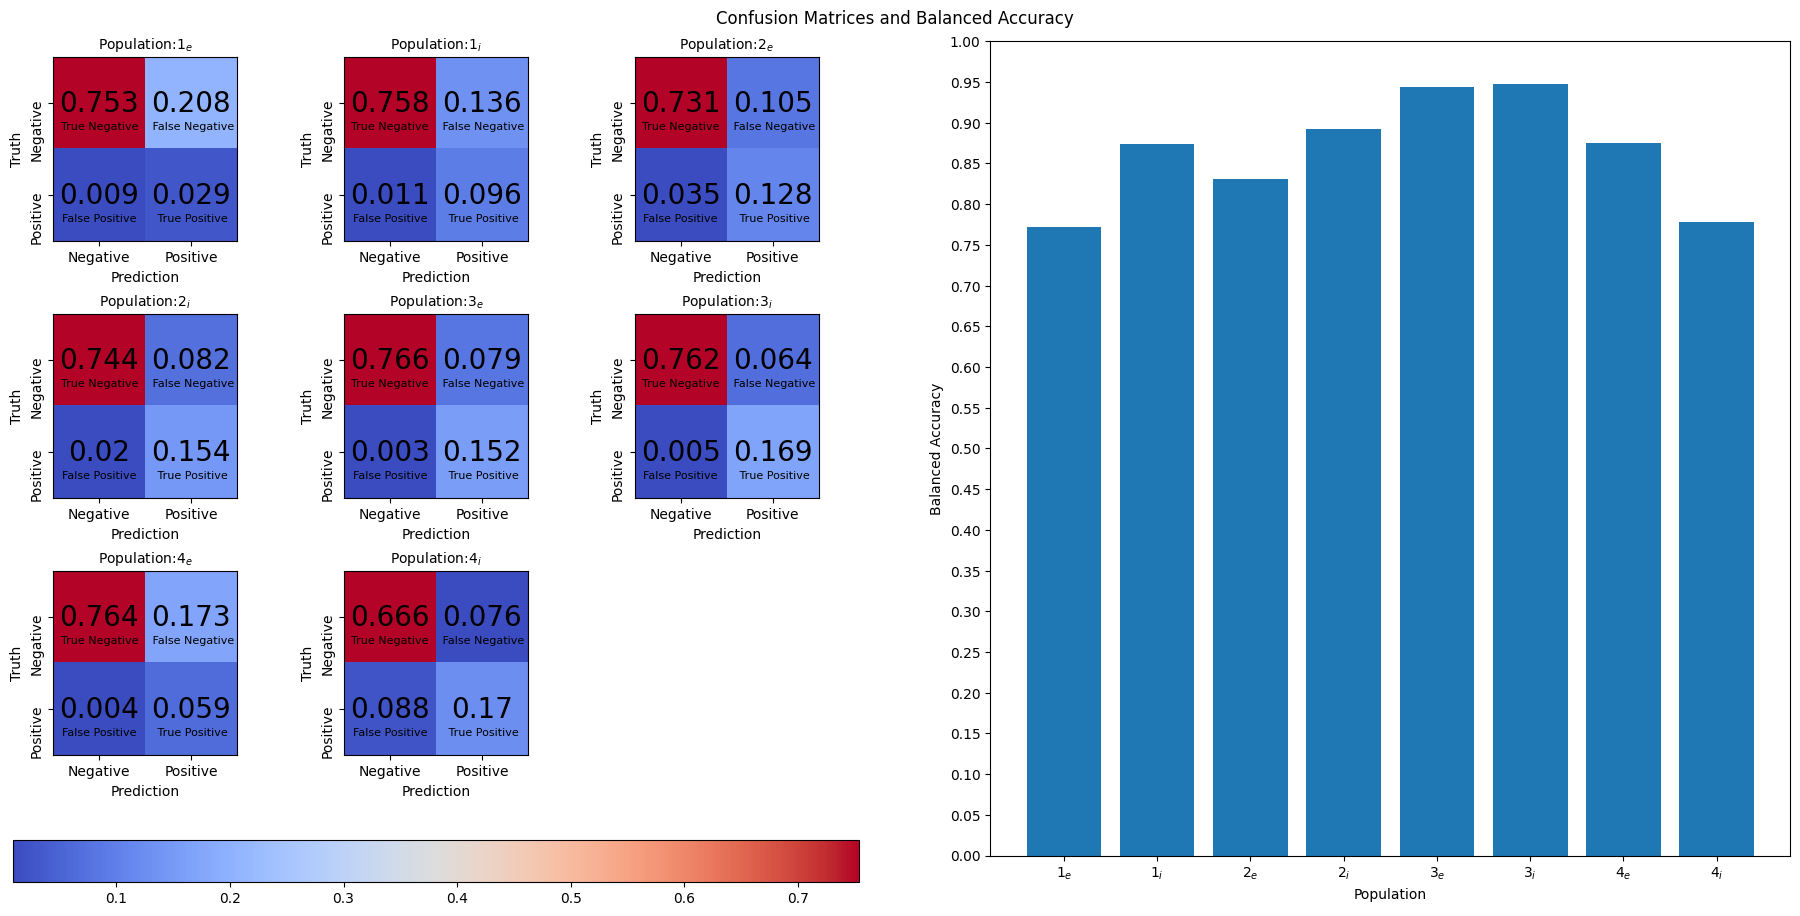

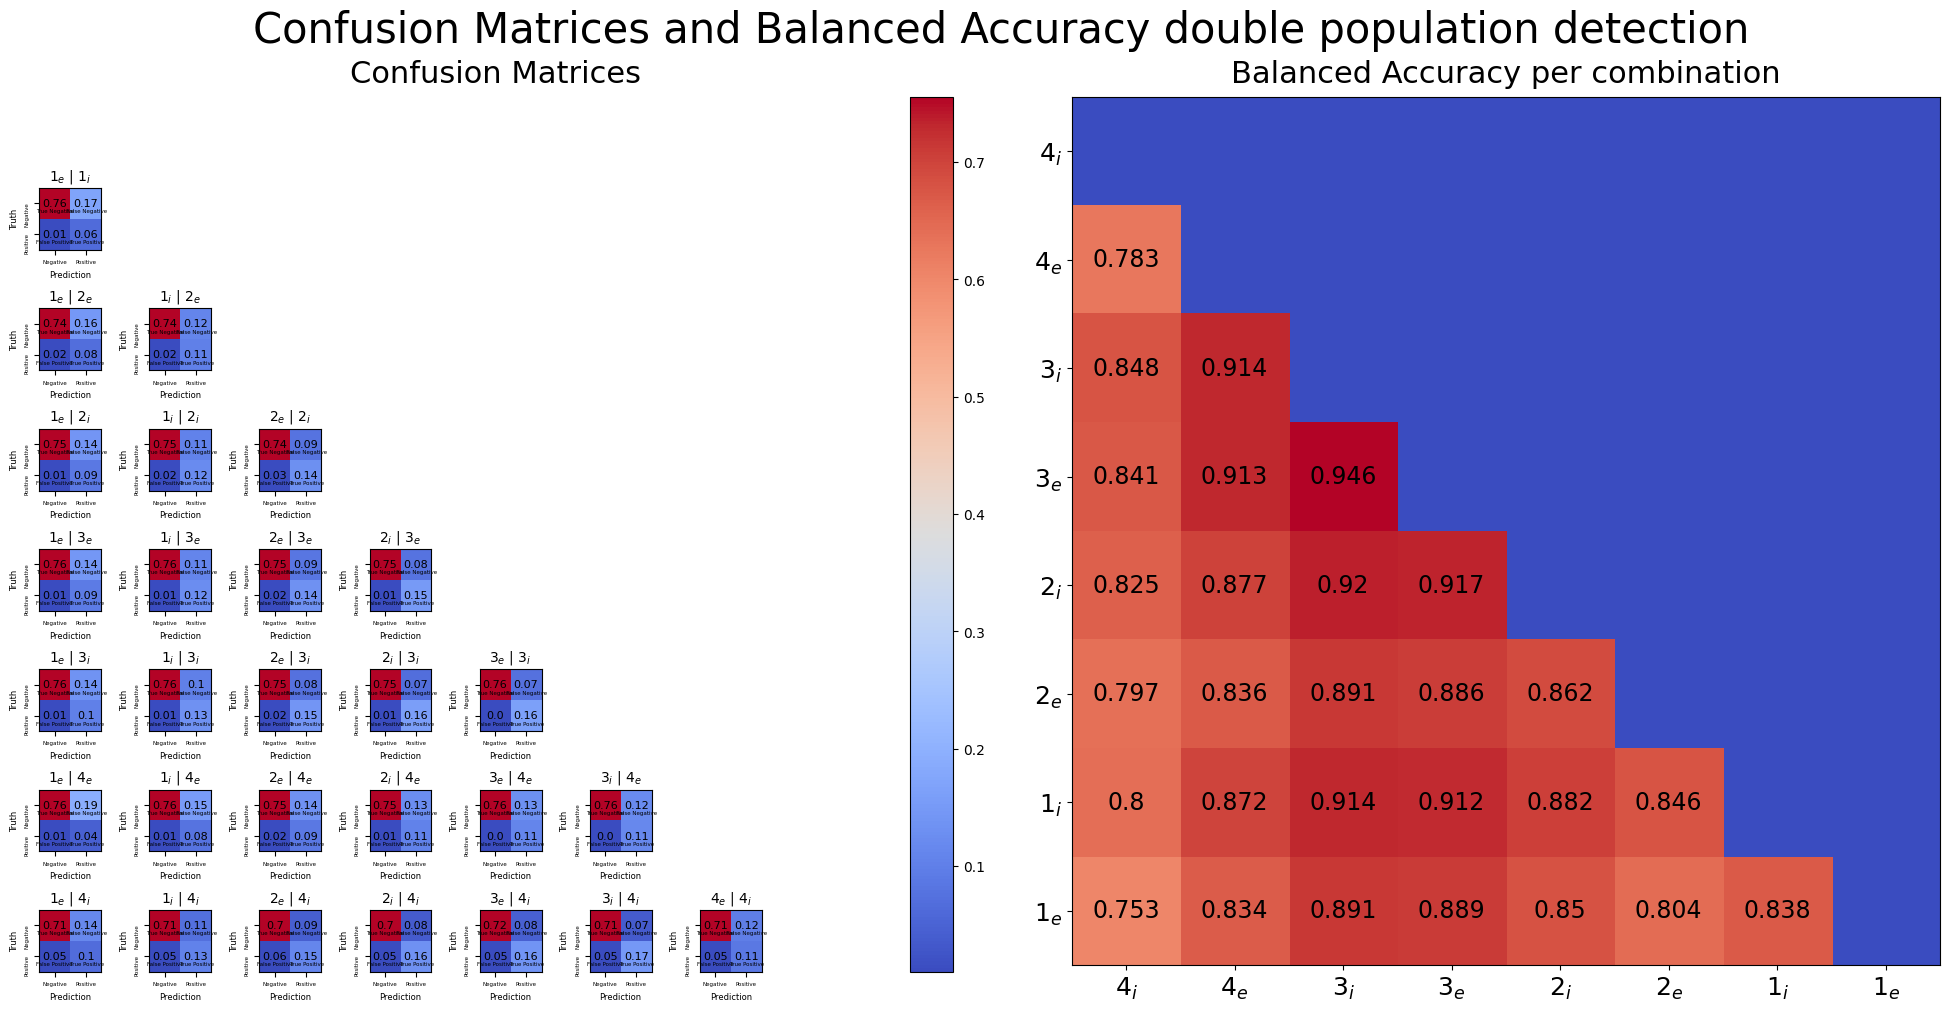

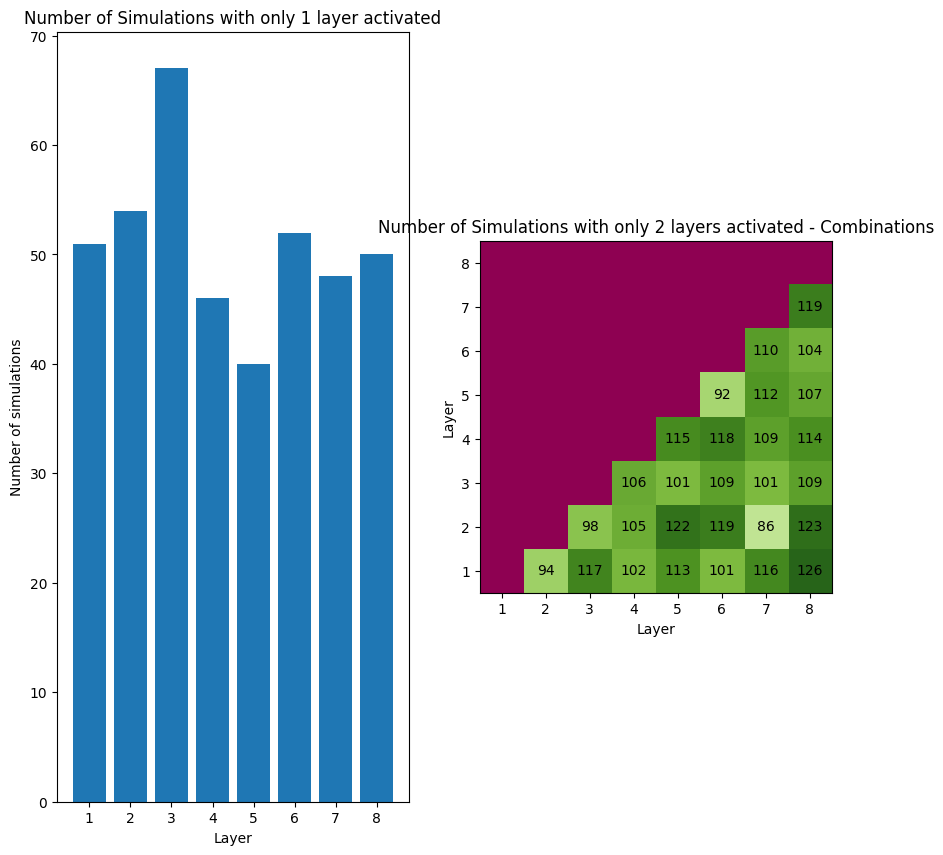

In [19]:
cur_test_suite_dir = os.path.join(cwd_path, 'plot_images', cur_test_name)

try:
    os.makedirs(cur_test_suite_dir)
except FileExistsError:
    pass
with open(os.path.join(cwd_path, 'plot_images', cur_test_suite_dir, 'test_params.txt'), 'w') as f:
        f.write("Posterior Prefix: " + posterior_prefix)
        f.write("Testing Prefix:   " + test_mat_prefix)
        f.write("Threshold: " + str(threshold) + "\n")
        f.write("Tolerance: " + str(tolerance) + "\n")
        f.write("Activation Threshold: " + str(activation_threshold) + "\n")
        f.write("Number of Samples: " + str(num_samples) + "\n")

print("Saving plots...")
fig00 , _ = plot_average_accuracy(test_results_arr)
fig00.savefig(os.path.join(cur_test_suite_dir, 'average_accuracy'))
plt.close(fig00)
for test_indx in tqdm(range(len(test_results_arr)), unit=" model", colour="green", file=sys.stdout):
    
    test_result = test_results_arr[test_indx]
    
    cur_test_dir = os.path.join(cwd_path, 'plot_images', cur_test_suite_dir, os.path.splitext(combi[test_indx][0][0])[0])
    
    
    
    try:
        os.mkdir(cur_test_dir)
    except FileExistsError:
        pass
    
    fig1 = plot_confusion_matrices_and_balanced_accuracies(test_result)
    fig2 = plot_confusion_matrices_and_balanced_accuracies_combinations(test_result)
    fig3, _ = plot_layer_combinations(combi[test_indx][1][1])
    
    
    fig1.savefig(os.path.join(cur_test_dir, 'accuracy'))  
    fig2.savefig(os.path.join(cur_test_dir, 'accuracy_combinations'))  
    fig3.savefig(os.path.join(cur_test_dir, 'activation_population_inputs'))
    
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)